<a href="https://colab.research.google.com/github/andreasfloros/ARM-ML-Embedded/blob/main/dataset_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Download and untar dataset directly to colab:**

In [9]:
import os
import requests
import tarfile

os.mkdir('audio_data/')
url = 'http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz'
target_path = 'audio_data/dataset.tar.gz'

response = requests.get(url, stream=True)
if response.status_code == 200:
    with open(target_path, 'wb') as f:
        f.write(response.raw.read())

tar = tarfile.open(target_path, "r:gz")
tar.extractall(path='audio_data/')
tar.close()

FileExistsError: ignored

**Organise data from original dataset and perform preprocessing:**

Preprocessing consists of STFT and averaging on window excerpts of the signal, resulting in a 49x43 matrix of values for each audio sample.

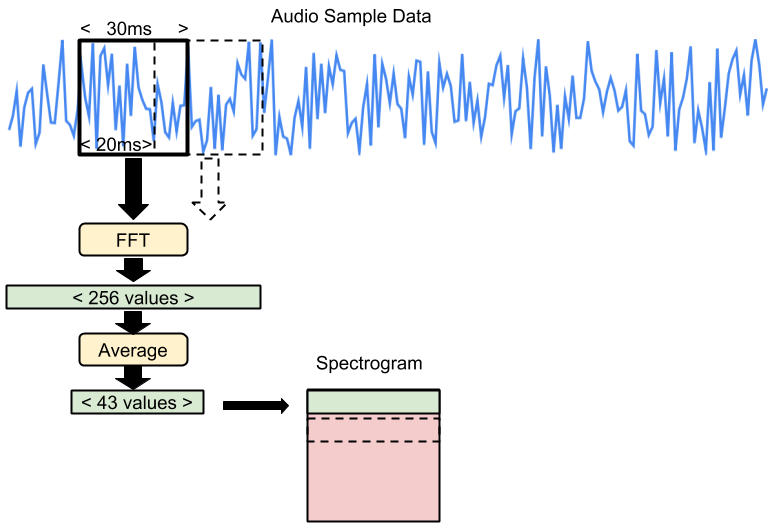

(16000,)
STFT hop length duration is: 0.020625s
STFT window duration is: 0.032s
(257, 49)
(257, 49)
(49, 257)


Text(0.5, 1.0, 'Spectrogram (dB)')

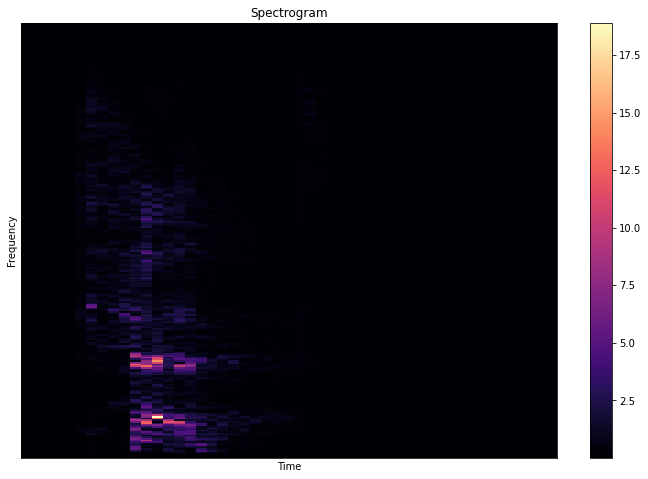

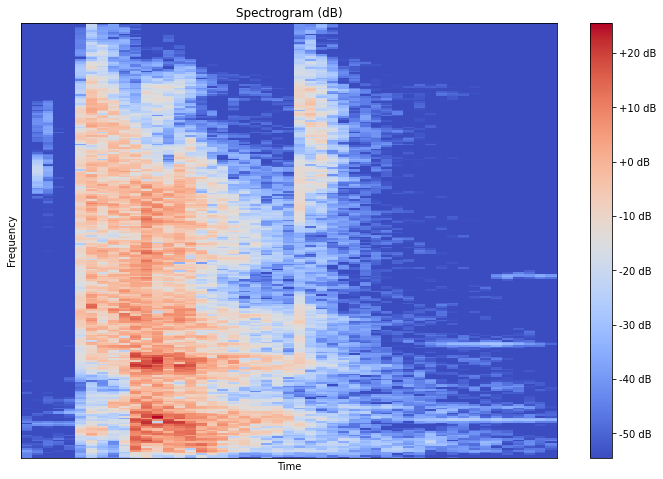

In [30]:
import numpy as np
import librosa, librosa.display
import matplotlib.pyplot as plt

FIG_SIZE = (12,8)

file = "audio_data/cat/f0522ff4_nohash_0.wav"

# load audio file with Librosa
signal, sample_rate = librosa.load(file, sr=16000)

print(signal.shape)

# # WAVEFORM
# # display waveform
# plt.figure(figsize=FIG_SIZE)
# librosa.display.waveplot(signal, sample_rate, alpha=0.4)
# plt.xlabel("Time (s)")
# plt.ylabel("Amplitude")
# plt.title("Waveform")


# # FFT -> power spectrum
# # perform Fourier transform
# fft = np.fft.fft(signal)

# # calculate abs values on complex numbers to get magnitude
# spectrum = np.abs(fft)

# # create frequency variable
# f = np.linspace(0, sample_rate, len(spectrum))

# # take half of the spectrum and frequency
# left_spectrum = spectrum[:int(len(spectrum)/2)]
# left_f = f[:int(len(spectrum)/2)]

# # plot spectrum
# plt.figure(figsize=FIG_SIZE)
# plt.plot(left_f, left_spectrum, alpha=0.4)
# plt.xlabel("Frequency")
# plt.ylabel("Magnitude")
# plt.title("Power spectrum")


# STFT -> spectrogram
n_fft = 512 # window in num. of samples
hop_length = 330 # in num. of samples


# calculate duration hop length and window in seconds
hop_length_duration = float(hop_length)/sample_rate
n_fft_duration = float(n_fft)/sample_rate

print("STFT hop length duration is: {}s".format(hop_length_duration))
print("STFT window duration is: {}s".format(n_fft_duration))

# perform stft
stft = librosa.stft(signal, n_fft=n_fft, hop_length=hop_length)

print(stft.shape)

# calculate abs values on complex numbers to get magnitude
spectrogram = np.abs(stft)

print(spectrogram.shape)

specT = spectrogram.transpose()

print(specT.shape)

# display spectrogram
plt.figure(figsize=FIG_SIZE)
librosa.display.specshow(spectrogram, sr=sample_rate, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.title("Spectrogram")

# apply logarithm to cast amplitude to Decibels
log_spectrogram = librosa.amplitude_to_db(spectrogram)

plt.figure(figsize=FIG_SIZE)
librosa.display.specshow(log_spectrogram, sr=sample_rate, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format="%+2.0f dB")
plt.title("Spectrogram (dB)")

In [35]:
import numpy as np

arr = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])

print("original: ", arr)

two   = np.mean(arr.reshape(-1, 2), axis=1)
three = np.mean(arr.reshape(-1, 3), axis=1)
four  = np.mean(arr.reshape(-1, 4), axis=1)
# five  = np.mean(arr.reshape(-1, 5), axis=1)


print("\n", arr.reshape(-1, 2))
print("two: ", two)
print("\n", arr.reshape(-1, 3))
print("three: ", three)
print("\n", arr.reshape(-1, 4))
print("four: ", four)
# print("\n", arr.reshape(-1, 5))
# print("five: ", five)

original:  [ 1  2  3  4  5  6  7  8  9 10 11 12]

 [[ 1  2]
 [ 3  4]
 [ 5  6]
 [ 7  8]
 [ 9 10]
 [11 12]]
two:  [ 1.5  3.5  5.5  7.5  9.5 11.5]

 [[ 1  2  3]
 [ 4  5  6]
 [ 7  8  9]
 [10 11 12]]
three:  [ 2.  5.  8. 11.]

 [[ 1  2  3  4]
 [ 5  6  7  8]
 [ 9 10 11 12]]
four:  [ 2.5  6.5 10.5]


**Functions for generating and displaying spectrogram**

In [ ]:
import librosa, librosa.display
import numpy as np
import matplotlib.pyplot as plt

def spectrogram_from_sample(sample, window_size, window_stride):
  stft = librosa.core.stft(sample, hop_length = window_stride, n_fft = window_size)
  spectrogram = np.abs(stft)


def plot_spectrogram(spectrogram, sample_rate, window_stride)
  librosa.display.specshow(spectrogram, sr=sample_rate, hop_length=window_stride)
  plt.xlabel("Time")
  plt.ylabel("Frequency")
  plt.colorbar()
  plt.title("Spectrogram")



**Convert entire dataset to spectrograms**

In [8]:
import os
import librosa
import math


DATASET_ROOT_DIR = 'audio_data/'
SAMPLE_RATE = 16000
WINDOW_SIZE_SAMPLES = 480
WINDOW_STRIDE_SAMPLES = 320
MFCC_COEFF_NUMBER = 13
EXPECTED_NUM_SAMPLES_PER_TRACK = SAMPLE_RATE # since audio track is expected to be 1 second long


def make_track_correct_size(signal, expected_num_samples_per_track):
    if len(signal) < expected_num_samples_per_track:
      num_zeros_to_pad = expected_num_samples_per_track - len(signal)
      zeros = num_zeros_to_pad * [0.]
      signal.extend(zeros)
      return signal

    elif len(signal) > expected_num_samples_per_track:
      return signal[:expected_num_samples_per_track]
      
    else:
      return signal


def convert_audio_dataset_to_mfcc():
  data = {
      'mapping' : [],
      'mfcc' : [],
      'labels' : []
  }

  # iterate through all word subfolders
  for i, (dirpath, dirnames, filenames) in enumerate(os.walk(DATASET_ROOT_DIR)):

    # # ensure we are not at the dataset root directory
    # # (os.walk provides this directory as well)
    # if dirpath is not DATASET_ROOT_DIR:

    if dirpath == 'audio_data/_background_noise_':

      # obtain word labels
      dirpath_components = dirpath.split('/') # audio_data/left => ['audio_data', 'left']
      word_label = dirpath_components[-1]
      data['mapping'].append(word_label)


      # expected_num_mfcc_vectors_per_track = math.ceil(EXPECTED_NUM_SAMPLES_PER_TRACK / WINDOW_STRIDE_SAMPLES)


      # access and process files for current word
      for f in filenames:
        
        # load audio file
        file_path = os.path.join(dirpath, f)
        signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)

        signal_correct_size = make_track_correct_size(signal, EXPECTED_NUM_SAMPLES_PER_TRACK)

        # get MFCCs for the audio track
        mfcc = librosa.feature.mfcc(signal, 
                                    sr = sr, 
                                    n_fft = WINDOW_SIZE_SAMPLES, 
                                    n_mfcc = MFCC_COEFF_NUMBER,
                                    hop_length = WINDOW_STRIDE_SAMPLES)
        
        transposed_mfcc = mfcc.T


yeh
pink_noise.wav
README.md
exercise_bike.wav
running_tap.wav
dude_miaowing.wav
doing_the_dishes.wav
white_noise.wav


In [17]:
import os
import librosa
import math





988891
15500
[1, 2, 3, 4]
[0.0, 0.0, 0.0, 0.0]
[1, 2, 3, 4, 0.0, 0.0, 0.0, 0.0]


**Build model:**

In [ ]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import matplotlib.pyplot as plt

DATA_PATH = "/content/sample_data/data_100.json"

def load_data(data_path):
    """Loads training dataset from json file.
        :param data_path (str): Path to json file containing data
        :return X (ndarray): Inputs
        :return y (ndarray): Targets
    """

    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["mfcc"])
    print(X)
    y = np.array(data["labels"])
    return X, y


def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs
        :param history: Training history of model
        :return:
    """

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()


def prepare_datasets(test_size, validation_size):
    """Loads data and splits it into train, validation and test sets.
    :param test_size (float): Value in [0, 1] indicating percentage of data set to allocate to test split
    :param validation_size (float): Value in [0, 1] indicating percentage of train set to allocate to validation split
    :return X_train (ndarray): Input training set
    :return X_validation (ndarray): Input validation set
    :return X_test (ndarray): Input test set
    :return y_train (ndarray): Target training set
    :return y_validation (ndarray): Target validation set
    :return y_test (ndarray): Target test set
    """

    # load data
    X, y = load_data(DATA_PATH)

    # create train, validation and test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)
    print(X_train.shape)
    # add an axis to input sets
    X_train = X_train[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_validation, X_test, y_train, y_validation, y_test


def build_model(input_shape):
    """Generates CNN model
    :param input_shape (tuple): Shape of input set
    :return model: CNN model
    """

    # build network topology
    model = keras.Sequential()

    # 1st conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 2nd conv layer
    model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 3rd conv layer
    model.add(keras.layers.Conv2D(128, (2, 2), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # flatten output and feed it into dense layer
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))

    # output layer
    model.add(keras.layers.Dense(10, activation='softmax'))

    return model


def predict(model, X, y):
    """Predict a single sample using the trained model
    :param model: Trained classifier
    :param X: Input data
    :param y (int): Target
    """

    # add a dimension to input data for sample - model.predict() expects a 4d array in this case
    X = X[np.newaxis, ...] # array shape (1, 130, 13, 1)

    # perform prediction
    prediction = model.predict(X)

    # get index with max value
    predicted_index = np.argmax(prediction, axis=1)

    print("Target: {}, Predicted label: {}".format(y, predicted_index))


if __name__ == "__main__":

    # get train, validation, test splits
    X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.25, 0.2)

    # create network
    print(X_train.shape)
    input_shape = (X_train.shape[1], X_train.shape[2], 1)
    model = build_model(input_shape)

    # compile model
    optimiser = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    model.summary()

    # train model
    history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=30)

    # plot accuracy/error for training and validation
    plot_history(history)



FileNotFoundError: ignored

In [ ]:
model.save("model1.h5")

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

# pick a sample to predict from the test set
X_to_predict = X_test[100]
y_to_predict = y_test[100]

# predict sample
predict(model, X_to_predict, y_to_predict)


In [ ]:
import tensorflow as tf
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model to disk
open("model1.tflite", "wb").write(tflite_model)

import os
basic_model_size = os.path.getsize("model1.tflite")
print("Model is %d bytes" % basic_model_size)

In [ ]:
# !echo "const unsigned char model[] __attribute__((aligned(4))) = {"  > /content/model.h
# !cat model1.tflite | xxd -i                                  >> /content/model.h
# !echo "};"                                                          >> /content/model.h

# import os
# model_h_size = os.path.getsize("model.h")
# print(f"Header file, model.h, is {model_h_size:,} bytes.")
# print("\nOpen the side panel (refresh if needed). Double click model.h to download the file.")

In [ ]:
# Function: Convert some hex value into an array for C programming
def hex_to_c_array(hex_data, var_name):

  c_str = ''

  # Create header guard
  c_str += '#ifndef ' + var_name.upper() + '_H\n'
  c_str += '#define ' + var_name.upper() + '_H\n\n'

  # Add array length at top of file
  c_str += '\nunsigned int ' + var_name + '_len = ' + str(len(hex_data)) + ';\n'

  # Declare C variable
  c_str += 'unsigned char ' + var_name + '[] = {'
  hex_array = []
  for i, val in enumerate(hex_data) :

    # Construct string from hex
    hex_str = format(val, '#04x')

    # Add formatting so each line stays within 80 characters
    if (i + 1) < len(hex_data):
      hex_str += ','
    if (i + 1) % 12 == 0:
      hex_str += '\n '
    hex_array.append(hex_str)

  # Add closing brace
  c_str += '\n ' + format(' '.join(hex_array)) + '\n};\n\n'

  # Close out header guard
  c_str += '#endif //' + var_name.upper() + '_H'

  return c_str

In [ ]:
with open("model1" + '.h', 'w') as file:
  file.write(hex_to_c_array(tflite_model, "model1"))